# Tutorial 4: Training a spiking neural network on a spiking dataset (Spiking Heidelberg Digits)

Manu Srinath Halvagal (https://zenkelab.org/team/) and Friedemann Zenke (https://fzenke.net)

For more details on surrogate gradient learning, please see: 

> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Process Mag 36, 51–63.
> https://ieeexplore.ieee.org/document/8891809 and https://arxiv.org/abs/1901.09948

> Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2020). The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks. IEEE Transactions on Neural Networks and Learning Systems 1–14. 
> https://ieeexplore.ieee.org/document/9311226 and https://arxiv.org/abs/1910.07407"

In Tutorials 2 and 3, we have seen how to train a multi-layer spiking neural network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) along with an activity regularizer. However, the spiking activity input to the network was generated using a simple time-to-first-spike code. Here we apply the model to train a spiking network to learn the Spiking Heidelberg Digits dataset (https://compneuro.net/posts/2019-spiking-heidelberg-digits/). This dataset uses a more sophisticated cochlear model to generate the spike data corresponding to audio recordings of spoken digits (examples below).

![Image of Yaktocat](https://compneuro.net/img/hdspikes_digits_samples.png)

In [73]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils import data

from utils import get_shd_dataset

In [74]:
# The coarse network structure and the time steps are dicated by the SHD dataset. 
nb_inputs  = 700
nb_hidden  = 200
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 256

In [75]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

### Setup of the spiking dataset

In [76]:
# The coarse network structure is dicated by the Fashion MNIST dataset.
nb_inputs  = 34*34 # https://greg-cohen.com/project/datasets/
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 20

In [77]:
torch.backends.mps.is_available()

True

In [78]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [79]:
## Load in the N-MNIST dataset
import tonic

train_dataset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=None, target_transform=None)
test_dataset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=None, target_transform=None)

In [80]:
len(train_dataset)

60000

In [81]:
train_dataset[0]

(array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
        ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
       dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]),
 0)

In [82]:
import torch.nn.functional as F

def preprocess_spike_events(spike_events, nb_steps=nb_steps, nb_units=nb_inputs, time_step=time_step):
    """
    Convert spike events into a binned spike train.

    Args:
        spike_events: Structured NumPy array of spike events (x, y, t, p).
        nb_steps: Number of time steps to bin the spikes into.
        nb_units: Number of neurons (x * y resolution).

    Returns:
        A binned spike train of shape (nb_steps, nb_units).
    """
    spike_train = np.zeros((nb_steps, nb_units), dtype=np.float32)
    for x, y, t, p in spike_events:
        if p == 1:  # Only process the event if p indicates a spike
            time_bin = int(t * time_step)  # Convert time to timestep
            if time_bin < nb_steps:
                neuron_id = x + y * int(np.sqrt(nb_inputs))  # Flatten 2D coordinates into 1D neuron ID
                spike_train[time_bin, neuron_id] += 1

    return torch.tensor(spike_train, dtype=torch.float32)

def custom_collate_fn(batch, num_classes=10):
    """
    Custom collate function to handle structured data and one-hot encode the labels.

    Args:
        batch: A list of samples (spike_events, label).
        num_classes: Number of classes for one-hot encoding.

    Returns:
        A tuple (spike_tensors, one_hot_labels).
    """
    spike_tensors = []
    labels = []

    for spike_events, label in batch:
        # Preprocess spike events
        spike_tensor = preprocess_spike_events(spike_events)
        spike_tensors.append(spike_tensor)

        # One-hot encode the label
        # one_hot_label = F.one_hot(torch.tensor(label, dtype=torch.int64), num_classes=num_classes)
        labels.append(label)

    # Stack spike tensors and labels into batches
    spike_tensors = torch.stack(spike_tensors)
    labels = torch.stack(labels)  # Convert list of one-hot labels into a batch
    return spike_tensors, labels


In [83]:
def get_representative_subset_indices(data, limit, num_inputs = 10):
    """
    Selects a representative subset of data point indices for PyTorch Subset,
    using the number of unique labels as the number of representatives.

    Args:
        labels (np.ndarray or list): Array/list of labels for each data point.

    Returns:
        torch.Tensor: Tensor of indices of the selected representative data points.
    """

    num_representatives = len(data)  # Use number of unique labels

    representatives_per_class = num_representatives//num_inputs
    sample_per_class = limit // num_inputs
    selected_indices = []
    for i in range(num_inputs):
        range_v = np.arange(i*representatives_per_class, (i+1)*representatives_per_class)
        selected_indices.extend(np.random.choice(range_v, sample_per_class, replace=False))
        # selected_indices.append(np.random.choice(indices, 1, replace=False).item()) #ensure only one item is selected.

    return torch.tensor(selected_indices)


In [84]:
from torch.utils.data import DataLoader, Subset, TensorDataset

train_limit = 100
test_limit = 100
# train_dataset = test_dataset
train_subset_indices = get_representative_subset_indices(train_dataset, train_limit)
test_subset_indices = get_representative_subset_indices(test_dataset, test_limit)

train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)

train_x_data = torch.stack([preprocess_spike_events(sample, nb_steps, nb_units=nb_inputs) for sample, _ in train_subset])
train_y_tensor = torch.tensor([label for _, label in train_subset], dtype=torch.int64)  # Shape: (num_samples,)

train_data = TensorDataset(train_x_data, train_y_tensor)

test_x_data = torch.stack([preprocess_spike_events(sample, nb_steps, nb_units=nb_inputs) for sample, _ in test_subset])
test_y_tensor = torch.tensor([label for _, label in test_subset], dtype=torch.int64)  # Shape: (num_samples,)

test_data = TensorDataset(test_x_data, test_y_tensor)


train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=custom_collate_fn,  # Use the custom collate function
    # num_workers=4,
    pin_memory=True,
    drop_last=True
)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# nb_steps = train_dataset[0][0].shape[0] # Get the number of time steps
nb_inputs = 34 * 34

In [85]:
test_data[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

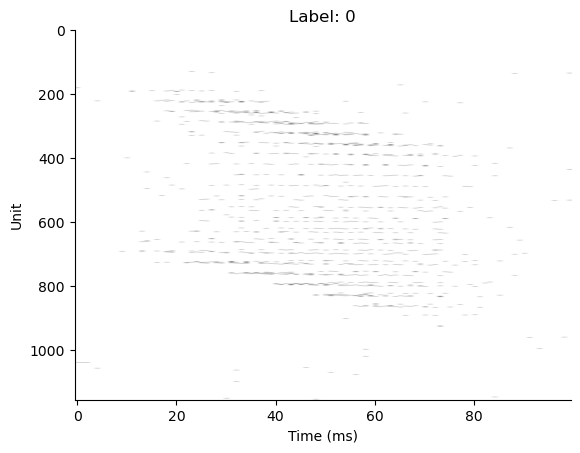

In [86]:
data_id = 2
plt.imshow(test_data[data_id][0].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.title(f"Label: {test_data[data_id][1]}")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

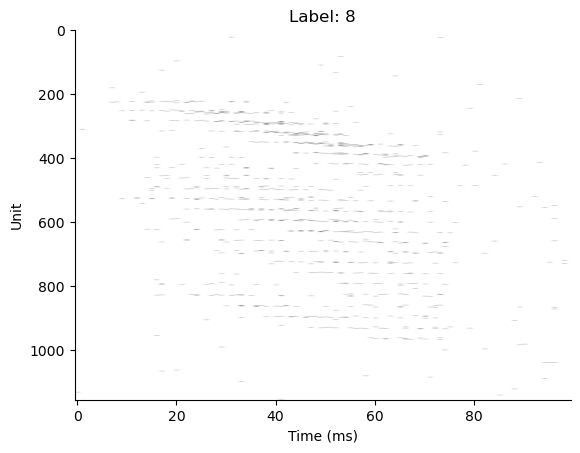

In [87]:
data_id = 80
plt.imshow(train_data[data_id][0].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.title(f"Label: {train_data[data_id][1]}")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

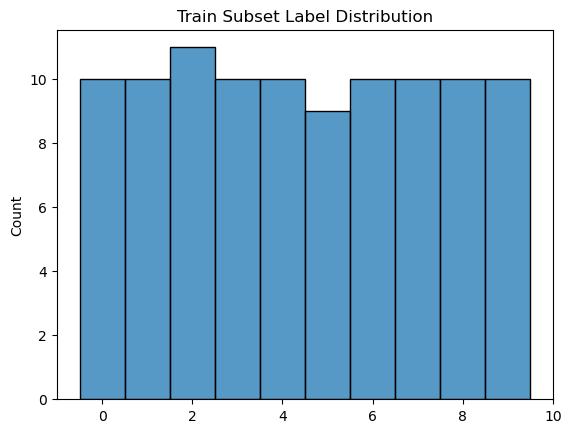

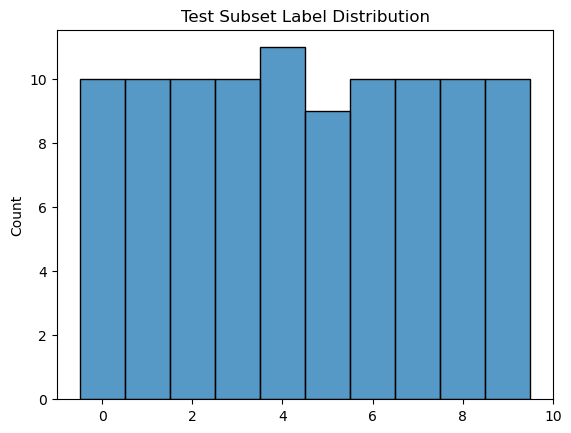

In [88]:
# Check distribution for each subset using train_loader.dataset[i][1]
train_labels = [int(train_loader.dataset[i][1]) for i in range(len(train_loader.dataset))]
test_labels = [int(test_loader.dataset[i][1]) for i in range(len(test_loader.dataset))]
sns.histplot(train_labels, discrete=True)
plt.title('Train Subset Label Distribution')
plt.show()
sns.histplot(test_labels, discrete=True)
plt.title('Test Subset Label Distribution')
plt.show()

### Setup of the spiking network model

In [89]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Let's also now include recurrent weights in the hidden layer. This significantly improves performance on the SHD dataset .

In [90]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [91]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [92]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3,2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    sns.despine()
    plt.show()

## Training the network

In [93]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

run_snn is also changed now in order to include the recurrent input in the hidden layer computation.

In [94]:
def run_snn(inputs):
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:,t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1
        new_mem =(beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [95]:
def train(data_loader, lr=1e-3, nb_epochs=10):
    
    params = [w1,w2,v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in data_loader:
            x_local = x_local.to(device)
            y_local = y_local.to(device)

            output,recs = run_snn(x_local)

            _,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 2e-6*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 2e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        live_plot(loss_hist)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
    return loss_hist
        
        
from sklearn.metrics import confusion_matrix

def compute_classification_accuracy(data_loader):
    """ 
    Computes classification accuracy and confusion matrix on supplied data in batches.
    
    Returns:
        accuracy: Overall classification accuracy.
        conf_matrix: Confusion matrix of shape (num_classes, num_classes).
    """
    accs = []
    all_preds = []
    all_labels = []

    for x_local, y_local in data_loader:
        # Move data to the appropriate device
        x_local, y_local = x_local.to(device), y_local.to(device)

        # Run the SNN model
        output, _ = run_snn(x_local)

        # Compute predictions
        m, _ = torch.max(output, 1)  # Max over time
        _, preds = torch.max(m, 1)   # Argmax over output units

        # Compute accuracy for the current batch
        correct = (y_local == preds).float()  # Shape: [batch_size]
        tmp = correct.mean().item()  # Accuracy for the current batch
        accs.append(tmp)

        # Store predictions and labels for the confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_local.cpu().numpy())

    # Compute overall accuracy
    accuracy = np.mean(accs)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    """ Plots the confusion matrix. """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [96]:
nb_epochs = 40

WARNING: Training for a large number of epochs could take a significant amount of time. Reduce the nb_epochs parameter as necessary.

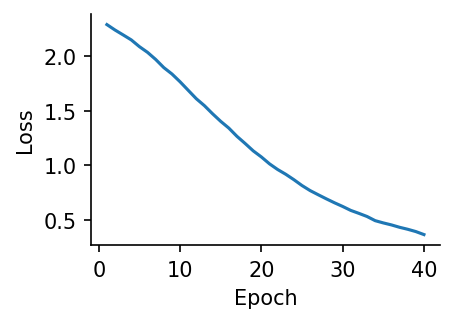

Epoch 40: loss=0.36281


In [97]:
loss_hist = train(train_loader, lr=2e-4, nb_epochs=nb_epochs)

train Accuracy: 97.00%


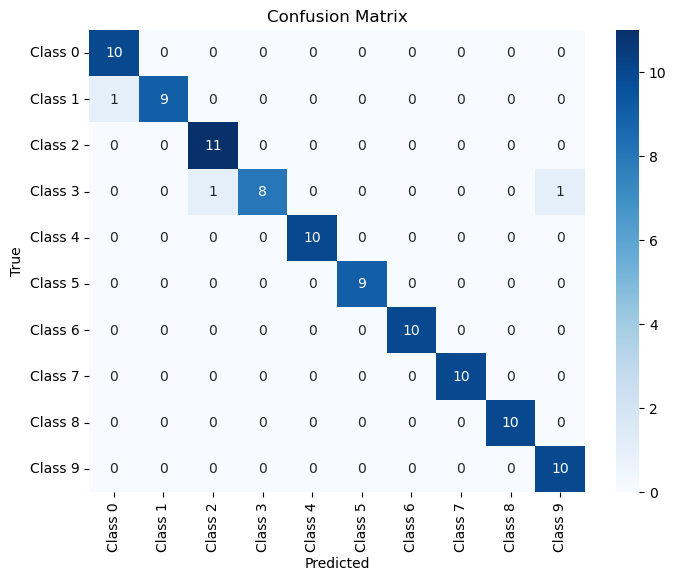

In [98]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(train_loader)

# Print results
print(f"train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names)


Test Accuracy: 80.00%


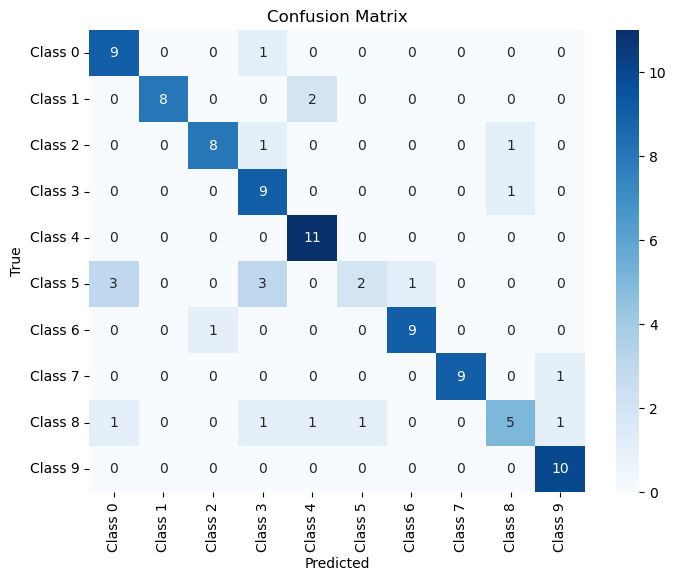

In [99]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(test_loader)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names)


In [100]:
def get_mini_batch(data_loader, shuffle=False):
    for ret in data_loader:
        return ret

In [101]:
x_batch, y_batch = get_mini_batch(test_loader)
x_batch = x_batch.to(device)
output, other_recordings = run_snn(x_batch)
mem_rec, spk_rec = other_recordings

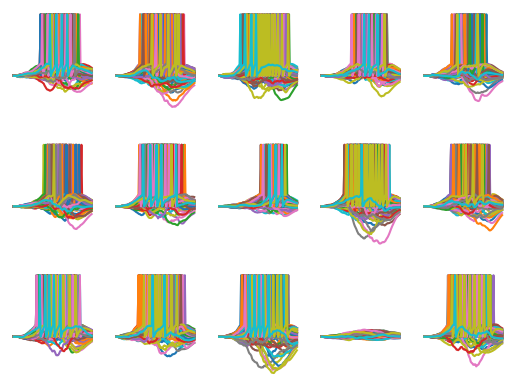

In [102]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

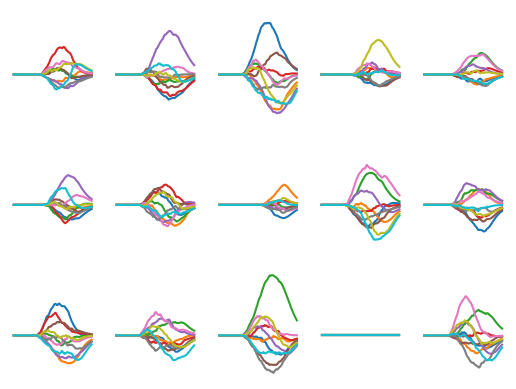

In [103]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

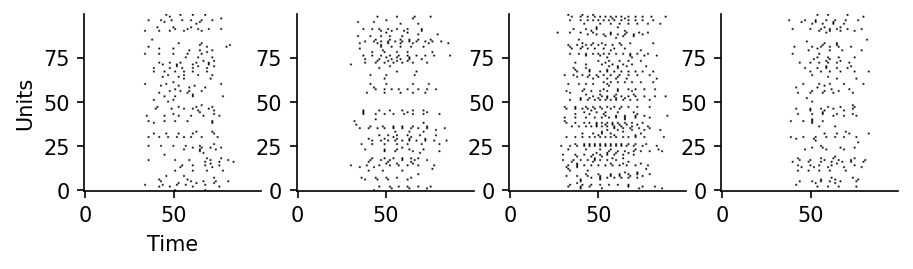

In [104]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

We see that spiking in the hidden layer is quite sparse as in the previous Tutorial 3 because we used the same activity regularizer.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.